In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
#     aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 aloss:0.7041 eloss:2.3148 aloss2:1.2491 exploreP:0.9979
Episode:1 meanR:20.0000 R:19.0000 rate:0.0380 aloss:0.7098 eloss:2.2812 aloss2:1.2730 exploreP:0.9960
Episode:2 meanR:29.6667 R:49.0000 rate:0.0980 aloss:0.7025 eloss:2.3076 aloss2:1.2575 exploreP:0.9912
Episode:3 meanR:30.7500 R:34.0000 rate:0.0680 aloss:0.7007 eloss:2.2552 aloss2:1.2824 exploreP:0.9879
Episode:4 meanR:29.6000 R:25.0000 rate:0.0500 aloss:0.7076 eloss:2.2825 aloss2:1.2671 exploreP:0.9855
Episode:5 meanR:27.1667 R:15.0000 rate:0.0300 aloss:0.7026 eloss:2.3130 aloss2:1.2551 exploreP:0.9840
Episode:6 meanR:31.2857 R:56.0000 rate:0.1120 aloss:0.6978 eloss:2.2308 aloss2:1.2937 exploreP:0.9786
Episode:7 meanR:31.7500 R:35.0000 rate:0.0700 aloss:0.7017 eloss:2.2199 aloss2:1.2998 exploreP:0.9752
Episode:8 meanR:30.5556 R:21.0000 rate:0.0420 aloss:0.7066 eloss:2.2442 aloss2:1.2892 exploreP:0.9731
Episode:9 meanR:28.6000 R:11.0000 rate:0.0220 aloss:0.7063 eloss:2.2946 aloss2:1.2

Episode:80 meanR:24.0123 R:85.0000 rate:0.1700 aloss:0.6904 eloss:2.1810 aloss2:1.5514 exploreP:0.8250
Episode:81 meanR:24.3902 R:55.0000 rate:0.1100 aloss:0.6791 eloss:2.1108 aloss2:1.5997 exploreP:0.8205
Episode:82 meanR:24.2410 R:12.0000 rate:0.0240 aloss:0.6828 eloss:2.1037 aloss2:1.6071 exploreP:0.8196
Episode:83 meanR:24.1905 R:20.0000 rate:0.0400 aloss:0.6823 eloss:2.0510 aloss2:1.6387 exploreP:0.8180
Episode:84 meanR:24.0706 R:14.0000 rate:0.0280 aloss:0.6960 eloss:2.0443 aloss2:1.6407 exploreP:0.8168
Episode:85 meanR:24.0000 R:18.0000 rate:0.0360 aloss:0.6886 eloss:2.0193 aloss2:1.6722 exploreP:0.8154
Episode:86 meanR:24.0575 R:29.0000 rate:0.0580 aloss:0.6945 eloss:2.0393 aloss2:1.6537 exploreP:0.8130
Episode:87 meanR:23.9773 R:17.0000 rate:0.0340 aloss:0.6840 eloss:2.0087 aloss2:1.6732 exploreP:0.8117
Episode:88 meanR:23.8315 R:11.0000 rate:0.0220 aloss:0.6845 eloss:1.9715 aloss2:1.6915 exploreP:0.8108
Episode:89 meanR:24.0556 R:44.0000 rate:0.0880 aloss:0.6794 eloss:1.9550 

Episode:159 meanR:37.2800 R:24.0000 rate:0.0480 aloss:0.6802 eloss:1.0271 aloss2:2.7442 exploreP:0.6049
Episode:160 meanR:37.3300 R:18.0000 rate:0.0360 aloss:0.6806 eloss:1.0498 aloss2:2.7146 exploreP:0.6038
Episode:161 meanR:37.3300 R:14.0000 rate:0.0280 aloss:0.6826 eloss:1.0655 aloss2:2.8047 exploreP:0.6030
Episode:162 meanR:37.4800 R:30.0000 rate:0.0600 aloss:0.6706 eloss:0.9733 aloss2:2.7428 exploreP:0.6012
Episode:163 meanR:38.7100 R:141.0000 rate:0.2820 aloss:0.6842 eloss:1.0107 aloss2:2.8435 exploreP:0.5930
Episode:164 meanR:39.3100 R:74.0000 rate:0.1480 aloss:0.6920 eloss:1.0092 aloss2:2.9527 exploreP:0.5887
Episode:165 meanR:39.8400 R:70.0000 rate:0.1400 aloss:0.6902 eloss:0.9804 aloss2:3.0247 exploreP:0.5846
Episode:166 meanR:39.9200 R:37.0000 rate:0.0740 aloss:0.6967 eloss:0.9486 aloss2:3.1413 exploreP:0.5825
Episode:167 meanR:40.7800 R:102.0000 rate:0.2040 aloss:0.6916 eloss:0.9017 aloss2:3.1686 exploreP:0.5767
Episode:168 meanR:40.6100 R:28.0000 rate:0.0560 aloss:0.6880 e

Episode:237 meanR:97.0600 R:242.0000 rate:0.4840 aloss:0.6875 eloss:-4.8249 aloss2:26.0515 exploreP:0.2615
Episode:238 meanR:97.8300 R:101.0000 rate:0.2020 aloss:0.6960 eloss:-5.4315 aloss2:26.6694 exploreP:0.2590
Episode:239 meanR:98.4400 R:108.0000 rate:0.2160 aloss:0.6903 eloss:-5.3697 aloss2:26.7817 exploreP:0.2563
Episode:240 meanR:98.3100 R:76.0000 rate:0.1520 aloss:0.6915 eloss:-5.3790 aloss2:27.3846 exploreP:0.2545
Episode:241 meanR:99.1600 R:114.0000 rate:0.2280 aloss:0.7007 eloss:-5.3173 aloss2:27.6740 exploreP:0.2517
Episode:242 meanR:100.2400 R:153.0000 rate:0.3060 aloss:0.6834 eloss:-4.4177 aloss2:27.7033 exploreP:0.2480
Episode:243 meanR:100.8200 R:143.0000 rate:0.2860 aloss:0.6898 eloss:-4.2883 aloss2:28.2345 exploreP:0.2447
Episode:244 meanR:101.3800 R:76.0000 rate:0.1520 aloss:0.6977 eloss:-5.9256 aloss2:28.4915 exploreP:0.2429
Episode:245 meanR:101.7100 R:93.0000 rate:0.1860 aloss:0.7042 eloss:-5.8228 aloss2:29.0205 exploreP:0.2407
Episode:246 meanR:102.1400 R:70.0000

Episode:314 meanR:140.4900 R:137.0000 rate:0.2740 aloss:0.7658 eloss:-7.1028 aloss2:45.7269 exploreP:0.0999
Episode:315 meanR:140.4400 R:166.0000 rate:0.3320 aloss:0.7430 eloss:-6.8640 aloss2:45.4388 exploreP:0.0984
Episode:316 meanR:140.7900 R:114.0000 rate:0.2280 aloss:0.7214 eloss:-7.5512 aloss2:45.9745 exploreP:0.0974
Episode:317 meanR:140.2000 R:113.0000 rate:0.2260 aloss:0.7462 eloss:-6.7940 aloss2:46.1696 exploreP:0.0964
Episode:318 meanR:136.8800 R:82.0000 rate:0.1640 aloss:0.7135 eloss:-7.1589 aloss2:46.0076 exploreP:0.0957
Episode:319 meanR:137.7200 R:191.0000 rate:0.3820 aloss:0.7191 eloss:-6.2522 aloss2:46.2823 exploreP:0.0941
Episode:320 meanR:137.5200 R:147.0000 rate:0.2940 aloss:0.7321 eloss:-7.2046 aloss2:46.0042 exploreP:0.0928
Episode:321 meanR:138.1100 R:179.0000 rate:0.3580 aloss:0.7161 eloss:-7.0804 aloss2:46.6241 exploreP:0.0914
Episode:322 meanR:138.2800 R:140.0000 rate:0.2800 aloss:0.7097 eloss:-7.4288 aloss2:46.8199 exploreP:0.0902
Episode:323 meanR:137.4300 R:

Episode:391 meanR:112.9100 R:47.0000 rate:0.0940 aloss:0.7696 eloss:-8.3836 aloss2:49.1174 exploreP:0.0515
Episode:392 meanR:111.6600 R:90.0000 rate:0.1800 aloss:0.8302 eloss:-7.2962 aloss2:49.1225 exploreP:0.0511
Episode:393 meanR:112.0900 R:182.0000 rate:0.3640 aloss:0.8092 eloss:-5.6995 aloss2:49.2962 exploreP:0.0503
Episode:394 meanR:111.2000 R:50.0000 rate:0.1000 aloss:0.7848 eloss:-6.9458 aloss2:49.4035 exploreP:0.0501
Episode:395 meanR:109.5200 R:103.0000 rate:0.2060 aloss:0.7545 eloss:-6.1910 aloss2:48.9873 exploreP:0.0497
Episode:396 meanR:108.7900 R:46.0000 rate:0.0920 aloss:0.8164 eloss:-7.7623 aloss2:48.8903 exploreP:0.0495
Episode:397 meanR:108.6400 R:41.0000 rate:0.0820 aloss:0.8003 eloss:-7.8196 aloss2:49.2936 exploreP:0.0494
Episode:398 meanR:107.4200 R:82.0000 rate:0.1640 aloss:0.8459 eloss:-7.8061 aloss2:49.3999 exploreP:0.0491
Episode:399 meanR:107.3400 R:148.0000 rate:0.2960 aloss:0.7467 eloss:-8.0031 aloss2:49.4891 exploreP:0.0485
Episode:400 meanR:106.3500 R:140.0

Episode:468 meanR:87.8100 R:42.0000 rate:0.0840 aloss:0.6978 eloss:-8.5715 aloss2:51.1129 exploreP:0.0314
Episode:469 meanR:88.1700 R:121.0000 rate:0.2420 aloss:0.6978 eloss:-7.8710 aloss2:51.1705 exploreP:0.0312
Episode:470 meanR:88.9900 R:138.0000 rate:0.2760 aloss:0.7070 eloss:-8.2405 aloss2:51.4577 exploreP:0.0309
Episode:471 meanR:89.9500 R:162.0000 rate:0.3240 aloss:0.7210 eloss:-6.8176 aloss2:51.3741 exploreP:0.0306
Episode:472 meanR:89.4300 R:43.0000 rate:0.0860 aloss:0.7075 eloss:-7.1689 aloss2:51.1100 exploreP:0.0305
Episode:473 meanR:88.1300 R:41.0000 rate:0.0820 aloss:0.7080 eloss:-7.9761 aloss2:51.3581 exploreP:0.0304
Episode:474 meanR:87.5900 R:82.0000 rate:0.1640 aloss:0.6915 eloss:-8.1357 aloss2:51.6929 exploreP:0.0302
Episode:475 meanR:87.9600 R:120.0000 rate:0.2400 aloss:0.7127 eloss:-6.4530 aloss2:51.6116 exploreP:0.0300
Episode:476 meanR:87.7300 R:34.0000 rate:0.0680 aloss:0.7098 eloss:-7.9536 aloss2:51.9435 exploreP:0.0299
Episode:477 meanR:87.3200 R:44.0000 rate:0

Episode:546 meanR:52.9000 R:32.0000 rate:0.0640 aloss:0.6822 eloss:-9.1018 aloss2:52.3536 exploreP:0.0252
Episode:547 meanR:52.7200 R:36.0000 rate:0.0720 aloss:0.7006 eloss:-7.8938 aloss2:52.2175 exploreP:0.0251
Episode:548 meanR:52.6200 R:38.0000 rate:0.0760 aloss:0.6972 eloss:-6.9756 aloss2:52.3178 exploreP:0.0251
Episode:549 meanR:51.8500 R:29.0000 rate:0.0580 aloss:0.6895 eloss:-7.4427 aloss2:52.1239 exploreP:0.0250
Episode:550 meanR:51.6400 R:36.0000 rate:0.0720 aloss:0.6922 eloss:-7.0941 aloss2:51.9746 exploreP:0.0250
Episode:551 meanR:51.4700 R:35.0000 rate:0.0700 aloss:0.7110 eloss:-2.7055 aloss2:51.8210 exploreP:0.0249
Episode:552 meanR:51.3000 R:34.0000 rate:0.0680 aloss:0.6876 eloss:-6.8878 aloss2:52.5639 exploreP:0.0249
Episode:553 meanR:50.6400 R:28.0000 rate:0.0560 aloss:0.7103 eloss:-6.7691 aloss2:51.5415 exploreP:0.0248
Episode:554 meanR:50.3600 R:33.0000 rate:0.0660 aloss:0.7063 eloss:-7.1252 aloss2:51.7706 exploreP:0.0248
Episode:555 meanR:50.1800 R:111.0000 rate:0.22

Episode:624 meanR:41.5900 R:42.0000 rate:0.0840 aloss:0.6819 eloss:-2.2785 aloss2:52.1697 exploreP:0.0208
Episode:625 meanR:41.5200 R:38.0000 rate:0.0760 aloss:0.6856 eloss:-8.5210 aloss2:52.4282 exploreP:0.0208
Episode:626 meanR:41.6800 R:42.0000 rate:0.0840 aloss:0.6742 eloss:-8.8329 aloss2:52.6140 exploreP:0.0207
Episode:627 meanR:41.8800 R:39.0000 rate:0.0780 aloss:0.6830 eloss:-8.1284 aloss2:52.6800 exploreP:0.0207
Episode:628 meanR:41.9900 R:34.0000 rate:0.0680 aloss:0.6781 eloss:-6.1101 aloss2:52.3313 exploreP:0.0206
Episode:629 meanR:42.0000 R:40.0000 rate:0.0800 aloss:0.6726 eloss:-7.1079 aloss2:52.3827 exploreP:0.0206
Episode:630 meanR:41.9500 R:35.0000 rate:0.0700 aloss:0.6787 eloss:-6.5234 aloss2:52.5412 exploreP:0.0206
Episode:631 meanR:42.0200 R:40.0000 rate:0.0800 aloss:0.6727 eloss:-9.2452 aloss2:52.4092 exploreP:0.0205
Episode:632 meanR:42.1000 R:42.0000 rate:0.0840 aloss:0.6750 eloss:-8.7492 aloss2:52.7946 exploreP:0.0205
Episode:633 meanR:42.0500 R:39.0000 rate:0.078

Episode:702 meanR:50.5900 R:44.0000 rate:0.0880 aloss:0.6651 eloss:-7.3537 aloss2:53.5085 exploreP:0.0172
Episode:703 meanR:50.7500 R:51.0000 rate:0.1020 aloss:0.6687 eloss:-8.7034 aloss2:53.4022 exploreP:0.0171
Episode:704 meanR:50.8400 R:54.0000 rate:0.1080 aloss:0.6704 eloss:-8.1390 aloss2:53.2387 exploreP:0.0171
Episode:705 meanR:51.6700 R:141.0000 rate:0.2820 aloss:0.6791 eloss:-7.7813 aloss2:53.6691 exploreP:0.0170
Episode:706 meanR:51.6500 R:49.0000 rate:0.0980 aloss:0.6736 eloss:-8.4538 aloss2:53.8075 exploreP:0.0169
Episode:707 meanR:51.6200 R:46.0000 rate:0.0920 aloss:0.6763 eloss:-6.3871 aloss2:53.5984 exploreP:0.0169
Episode:708 meanR:51.6400 R:47.0000 rate:0.0940 aloss:0.6670 eloss:-1.6539 aloss2:53.3297 exploreP:0.0169
Episode:709 meanR:52.4200 R:117.0000 rate:0.2340 aloss:0.6721 eloss:-7.7847 aloss2:53.6663 exploreP:0.0168
Episode:710 meanR:52.3200 R:40.0000 rate:0.0800 aloss:0.6875 eloss:-7.8977 aloss2:53.6548 exploreP:0.0168
Episode:711 meanR:52.3500 R:42.0000 rate:0.0

Episode:779 meanR:89.6500 R:46.0000 rate:0.0920 aloss:0.6594 eloss:-6.1190 aloss2:55.6343 exploreP:0.0133
Episode:780 meanR:89.5500 R:39.0000 rate:0.0780 aloss:0.6810 eloss:-6.5024 aloss2:55.8902 exploreP:0.0133
Episode:781 meanR:89.3700 R:94.0000 rate:0.1880 aloss:0.6781 eloss:-8.3456 aloss2:55.7725 exploreP:0.0133
Episode:782 meanR:89.3400 R:39.0000 rate:0.0780 aloss:0.6676 eloss:-5.2280 aloss2:55.9792 exploreP:0.0133
Episode:783 meanR:89.9900 R:111.0000 rate:0.2220 aloss:0.6675 eloss:-6.0033 aloss2:55.7930 exploreP:0.0132
Episode:784 meanR:90.6600 R:117.0000 rate:0.2340 aloss:0.6758 eloss:-6.9327 aloss2:55.7112 exploreP:0.0132
Episode:785 meanR:94.4200 R:430.0000 rate:0.8600 aloss:0.6786 eloss:-7.4553 aloss2:55.9833 exploreP:0.0131
Episode:786 meanR:94.9900 R:98.0000 rate:0.1960 aloss:0.6706 eloss:-8.0981 aloss2:56.1594 exploreP:0.0130
Episode:787 meanR:96.4600 R:190.0000 rate:0.3800 aloss:0.6650 eloss:-4.7233 aloss2:55.7405 exploreP:0.0130
Episode:788 meanR:98.8600 R:295.0000 rate:

Episode:856 meanR:138.9500 R:208.0000 rate:0.4160 aloss:0.6632 eloss:-6.0854 aloss2:55.8055 exploreP:0.0111
Episode:857 meanR:137.8300 R:31.0000 rate:0.0620 aloss:0.6886 eloss:-8.3064 aloss2:55.8532 exploreP:0.0111
Episode:858 meanR:136.7300 R:22.0000 rate:0.0440 aloss:0.6638 eloss:-7.0324 aloss2:55.8669 exploreP:0.0111
Episode:859 meanR:135.0700 R:32.0000 rate:0.0640 aloss:0.7368 eloss:-5.6806 aloss2:55.7570 exploreP:0.0111
Episode:860 meanR:134.0100 R:24.0000 rate:0.0480 aloss:0.7817 eloss:-7.4751 aloss2:55.5463 exploreP:0.0111
Episode:861 meanR:133.9500 R:34.0000 rate:0.0680 aloss:0.6670 eloss:-8.0338 aloss2:56.1922 exploreP:0.0111
Episode:862 meanR:133.0600 R:35.0000 rate:0.0700 aloss:0.7819 eloss:-2.0590 aloss2:55.5004 exploreP:0.0111
Episode:863 meanR:132.9600 R:30.0000 rate:0.0600 aloss:0.6840 eloss:-9.0039 aloss2:56.0873 exploreP:0.0111
Episode:864 meanR:129.5000 R:26.0000 rate:0.0520 aloss:0.6730 eloss:-7.1225 aloss2:56.0563 exploreP:0.0111
Episode:865 meanR:128.6600 R:32.0000

Episode:933 meanR:63.2800 R:48.0000 rate:0.0960 aloss:0.7225 eloss:-8.3761 aloss2:56.0800 exploreP:0.0107
Episode:934 meanR:59.0400 R:43.0000 rate:0.0860 aloss:0.6678 eloss:-8.4108 aloss2:55.9543 exploreP:0.0107
Episode:935 meanR:58.0000 R:49.0000 rate:0.0980 aloss:0.6470 eloss:-7.7768 aloss2:56.0540 exploreP:0.0107
Episode:936 meanR:58.9100 R:126.0000 rate:0.2520 aloss:0.6715 eloss:-6.3115 aloss2:56.0234 exploreP:0.0107
Episode:937 meanR:59.2000 R:43.0000 rate:0.0860 aloss:0.7125 eloss:-7.5654 aloss2:56.0869 exploreP:0.0107
Episode:938 meanR:59.7400 R:64.0000 rate:0.1280 aloss:0.6825 eloss:-6.4967 aloss2:56.0768 exploreP:0.0107
Episode:939 meanR:59.9500 R:34.0000 rate:0.0680 aloss:0.7078 eloss:-7.5505 aloss2:56.0297 exploreP:0.0107
Episode:940 meanR:60.2300 R:46.0000 rate:0.0920 aloss:0.7068 eloss:-8.2206 aloss2:56.3391 exploreP:0.0107
Episode:941 meanR:60.3300 R:39.0000 rate:0.0780 aloss:0.6569 eloss:-8.3307 aloss2:56.2727 exploreP:0.0107
Episode:942 meanR:60.5200 R:49.0000 rate:0.09

Episode:1011 meanR:44.9800 R:43.0000 rate:0.0860 aloss:0.6762 eloss:-7.7442 aloss2:56.3015 exploreP:0.0105
Episode:1012 meanR:45.1000 R:52.0000 rate:0.1040 aloss:0.7093 eloss:-4.2069 aloss2:56.1040 exploreP:0.0105
Episode:1013 meanR:45.0600 R:50.0000 rate:0.1000 aloss:0.6768 eloss:-7.6744 aloss2:56.2465 exploreP:0.0105
Episode:1014 meanR:45.0200 R:39.0000 rate:0.0780 aloss:0.6810 eloss:-5.9965 aloss2:56.2061 exploreP:0.0105
Episode:1015 meanR:45.0600 R:51.0000 rate:0.1020 aloss:0.6544 eloss:-7.8634 aloss2:56.1853 exploreP:0.0105
Episode:1016 meanR:44.9800 R:42.0000 rate:0.0840 aloss:0.6716 eloss:-6.1521 aloss2:56.1918 exploreP:0.0105
Episode:1017 meanR:44.9500 R:39.0000 rate:0.0780 aloss:0.6738 eloss:-8.6111 aloss2:56.3970 exploreP:0.0105
Episode:1018 meanR:44.9200 R:41.0000 rate:0.0820 aloss:0.6522 eloss:-6.9507 aloss2:56.2925 exploreP:0.0105
Episode:1019 meanR:44.8300 R:36.0000 rate:0.0720 aloss:0.7305 eloss:-5.3347 aloss2:56.3487 exploreP:0.0105
Episode:1020 meanR:44.8400 R:49.0000 

Episode:1088 meanR:44.6400 R:58.0000 rate:0.1160 aloss:0.6474 eloss:-8.6007 aloss2:56.0664 exploreP:0.0104
Episode:1089 meanR:45.0700 R:82.0000 rate:0.1640 aloss:0.6487 eloss:-8.5834 aloss2:56.0676 exploreP:0.0104
Episode:1090 meanR:45.2800 R:54.0000 rate:0.1080 aloss:0.6559 eloss:-8.6055 aloss2:56.0876 exploreP:0.0104
Episode:1091 meanR:45.5600 R:69.0000 rate:0.1380 aloss:0.6715 eloss:-5.4222 aloss2:56.1246 exploreP:0.0103
Episode:1092 meanR:45.9900 R:83.0000 rate:0.1660 aloss:0.6958 eloss:-7.3890 aloss2:56.2632 exploreP:0.0103
Episode:1093 meanR:45.8800 R:45.0000 rate:0.0900 aloss:0.6158 eloss:-2.4465 aloss2:55.8529 exploreP:0.0103
Episode:1094 meanR:46.5100 R:93.0000 rate:0.1860 aloss:0.6794 eloss:-4.1368 aloss2:55.9323 exploreP:0.0103
Episode:1095 meanR:46.4900 R:42.0000 rate:0.0840 aloss:0.6543 eloss:-6.1925 aloss2:55.8612 exploreP:0.0103
Episode:1096 meanR:46.7200 R:59.0000 rate:0.1180 aloss:0.6522 eloss:-7.2848 aloss2:56.0618 exploreP:0.0103
Episode:1097 meanR:46.8400 R:49.0000 

Episode:1165 meanR:54.5700 R:53.0000 rate:0.1060 aloss:0.6737 eloss:-6.1637 aloss2:57.5867 exploreP:0.0102
Episode:1166 meanR:54.6400 R:40.0000 rate:0.0800 aloss:0.6869 eloss:-0.7650 aloss2:57.4184 exploreP:0.0102
Episode:1167 meanR:54.7800 R:54.0000 rate:0.1080 aloss:0.7217 eloss:-9.4479 aloss2:57.7129 exploreP:0.0102
Episode:1168 meanR:54.6800 R:37.0000 rate:0.0740 aloss:0.6413 eloss:-5.8488 aloss2:57.5825 exploreP:0.0102
Episode:1169 meanR:54.8400 R:57.0000 rate:0.1140 aloss:0.6125 eloss:-8.0132 aloss2:57.5957 exploreP:0.0102
Episode:1170 meanR:55.0700 R:66.0000 rate:0.1320 aloss:0.6500 eloss:-8.1364 aloss2:57.7845 exploreP:0.0102
Episode:1171 meanR:55.1200 R:40.0000 rate:0.0800 aloss:0.6401 eloss:-5.4106 aloss2:57.6484 exploreP:0.0102
Episode:1172 meanR:55.2300 R:73.0000 rate:0.1460 aloss:0.6363 eloss:-8.5524 aloss2:57.8146 exploreP:0.0102
Episode:1173 meanR:55.3200 R:53.0000 rate:0.1060 aloss:0.6539 eloss:-7.7256 aloss2:57.8662 exploreP:0.0102
Episode:1174 meanR:55.2700 R:40.0000 

Episode:1242 meanR:117.1200 R:77.0000 rate:0.1540 aloss:0.5988 eloss:-6.5527 aloss2:60.9968 exploreP:0.0101
Episode:1243 meanR:117.0500 R:35.0000 rate:0.0700 aloss:0.5991 eloss:-7.5644 aloss2:60.9849 exploreP:0.0101
Episode:1244 meanR:116.9900 R:37.0000 rate:0.0740 aloss:0.6667 eloss:-5.2530 aloss2:60.6434 exploreP:0.0101
Episode:1245 meanR:116.5500 R:39.0000 rate:0.0780 aloss:0.5870 eloss:-7.1615 aloss2:60.8994 exploreP:0.0101
Episode:1246 meanR:116.5700 R:45.0000 rate:0.0900 aloss:0.5866 eloss:-7.8573 aloss2:61.0065 exploreP:0.0101
Episode:1247 meanR:116.4700 R:37.0000 rate:0.0740 aloss:0.5953 eloss:-8.0844 aloss2:61.1671 exploreP:0.0101
Episode:1248 meanR:116.2700 R:44.0000 rate:0.0880 aloss:0.6642 eloss:-5.5710 aloss2:61.1281 exploreP:0.0101
Episode:1249 meanR:116.1300 R:47.0000 rate:0.0940 aloss:0.6137 eloss:-8.3965 aloss2:61.2636 exploreP:0.0101
Episode:1250 meanR:116.0300 R:45.0000 rate:0.0900 aloss:0.6881 eloss:-1.2392 aloss2:61.0245 exploreP:0.0101
Episode:1251 meanR:115.7400 

Episode:1318 meanR:141.3900 R:500.0000 rate:1.0000 aloss:0.5711 eloss:-5.7374 aloss2:63.9521 exploreP:0.0100
Episode:1319 meanR:138.4900 R:210.0000 rate:0.4200 aloss:0.6296 eloss:-0.1727 aloss2:63.6376 exploreP:0.0100
Episode:1320 meanR:138.1400 R:40.0000 rate:0.0800 aloss:0.6021 eloss:-6.1117 aloss2:63.2533 exploreP:0.0100
Episode:1321 meanR:140.4700 R:266.0000 rate:0.5320 aloss:0.5731 eloss:-6.3432 aloss2:63.4678 exploreP:0.0100
Episode:1322 meanR:141.3700 R:136.0000 rate:0.2720 aloss:0.5637 eloss:-5.9174 aloss2:63.6659 exploreP:0.0100
Episode:1323 meanR:141.4000 R:64.0000 rate:0.1280 aloss:0.5750 eloss:-5.3753 aloss2:63.6531 exploreP:0.0100
Episode:1324 meanR:143.8100 R:278.0000 rate:0.5560 aloss:0.5584 eloss:-6.2834 aloss2:63.8402 exploreP:0.0100
Episode:1325 meanR:145.4500 R:199.0000 rate:0.3980 aloss:0.5772 eloss:-5.7037 aloss2:64.0293 exploreP:0.0100
Episode:1326 meanR:145.6500 R:54.0000 rate:0.1080 aloss:0.5789 eloss:-3.5210 aloss2:63.7977 exploreP:0.0100
Episode:1327 meanR:147

Episode:1394 meanR:173.3500 R:168.0000 rate:0.3360 aloss:0.5923 eloss:-6.7679 aloss2:64.2187 exploreP:0.0100
Episode:1395 meanR:174.7100 R:194.0000 rate:0.3880 aloss:0.6118 eloss:-4.6415 aloss2:64.1318 exploreP:0.0100
Episode:1396 meanR:175.7900 R:148.0000 rate:0.2960 aloss:0.5817 eloss:-2.5703 aloss2:64.0986 exploreP:0.0100
Episode:1397 meanR:175.4100 R:69.0000 rate:0.1380 aloss:0.6149 eloss:-7.0522 aloss2:64.1689 exploreP:0.0100
Episode:1398 meanR:174.5900 R:68.0000 rate:0.1360 aloss:0.5342 eloss:-7.5972 aloss2:64.5395 exploreP:0.0100
Episode:1399 meanR:173.3400 R:37.0000 rate:0.0740 aloss:0.6013 eloss:-7.2978 aloss2:64.4349 exploreP:0.0100
Episode:1400 meanR:173.4100 R:182.0000 rate:0.3640 aloss:0.5493 eloss:-3.5388 aloss2:64.4829 exploreP:0.0100
Episode:1401 meanR:169.6700 R:126.0000 rate:0.2520 aloss:0.5380 eloss:-7.1164 aloss2:64.5741 exploreP:0.0100
Episode:1402 meanR:169.3100 R:124.0000 rate:0.2480 aloss:0.5883 eloss:-3.3207 aloss2:64.2307 exploreP:0.0100
Episode:1403 meanR:168

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

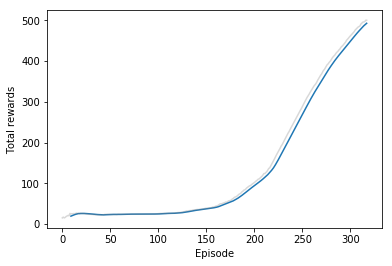

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

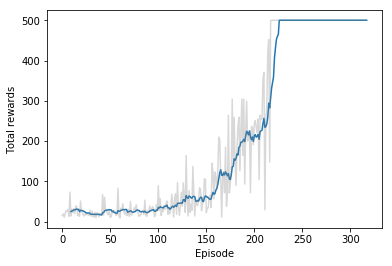

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

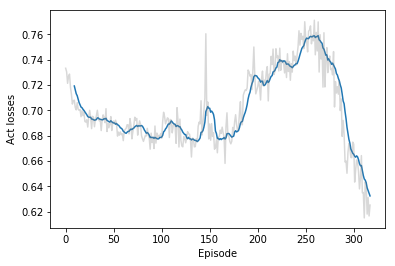

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

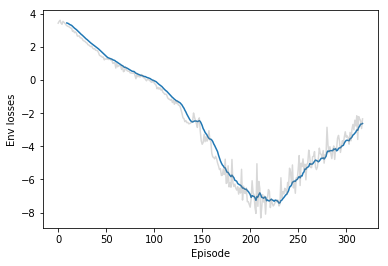

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

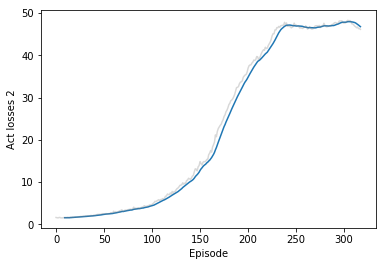

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
